In [14]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('mail_data.csv')

# Display the first 5 rows of the DataFrame
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
data['Message_Length'] = data['Message'].apply(len)
data.groupby('Category')['Message_Length'].mean()

Category
ham      71.44829
spam    137.98929
Name: Message_Length, dtype: float64

In [16]:
from collections import Counter
import re

words_in_spam = ' '.join(data[data['Category'] == 'spam']['Message']).lower()
spam_word_list = re.findall(r'\b\w+\b', words_in_spam)
spam_word_freq = Counter(spam_word_list).most_common(20)

print(spam_word_freq)

[('to', 688), ('a', 380), ('call', 352), ('you', 297), ('your', 264), ('free', 224), ('2', 207), ('for', 204), ('the', 203), ('now', 199), ('or', 188), ('u', 170), ('txt', 163), ('is', 157), ('on', 145), ('ur', 144), ('4', 137), ('have', 132), ('from', 131), ('mobile', 127)]


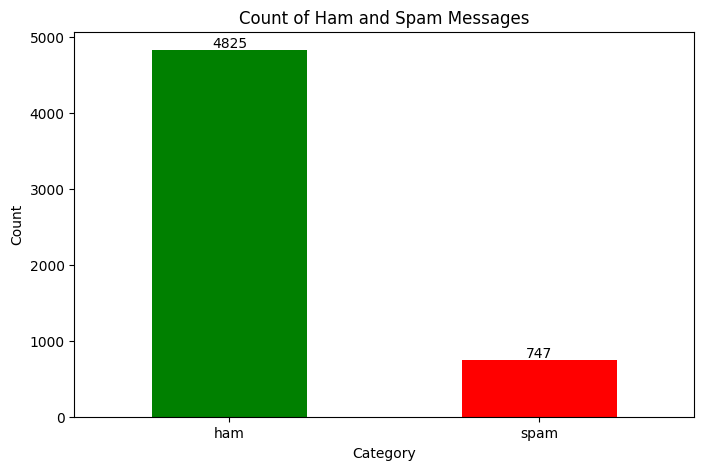

In [17]:
import matplotlib.pyplot as plt

# Count the occurrences of each category
category_counts = data['Category'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 5))
bars = category_counts.plot(kind='bar', color=['green', 'red'])

# Adding titles and labels
plt.title('Count of Ham and Spam Messages')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x labels if needed

# Display counts on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             int(bar.get_height()), ha='center', va='bottom')

# Show the plot
plt.show()

In [18]:
# Separate the ham and spam messages
ham_data = data[data['Category'] == 'ham']
spam_data = data[data['Category'] == 'spam']

# Oversample the spam messages
spam_oversampled = spam_data.sample(n=len(ham_data), replace=True)

# Combine ham and oversampled spam data
balanced_data = pd.concat([ham_data, spam_oversampled])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced dataset counts
print(balanced_data['Category'].value_counts())

Category
ham     4825
spam    4825
Name: count, dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib


# Split the data into features (X) and labels (y)
X = balanced_data['Message']
y = balanced_data['Category'].map({'ham': 0, 'spam': 1})  # Convert to numerical labels

In [20]:
print('\n')
print(X)

print('\n')
print(y)



0                 So what about you. What do you remember
1       My life Means a lot to me, Not because I love ...
2       E admin building there? I might b slightly ear...
3                    Sorry, went to bed early, nightnight
4       Someone has conacted our dating service and en...
                              ...                        
9645    As a SIM subscriber, you are selected to recei...
9646    Please CALL 08712402578 immediately as there i...
9647    Please CALL 08712402972 immediately as there i...
9648    Just buy a pizza. Meat lovers or supreme. U ge...
9649    Congrats! 1 year special cinema pass for 2 is ...
Name: Message, Length: 9650, dtype: object


0       0
1       0
2       0
3       0
4       1
       ..
9645    1
9646    1
9647    1
9648    0
9649    1
Name: Category, Length: 9650, dtype: int64


In [21]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase= True)

X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [23]:
# Create a pipeline with CountVectorizer and Logistic Regression
model = LogisticRegression()

# Fit the model
model.fit(X_train_features, y_train)

# Save the model to a file
joblib.dump(model, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [24]:
accuracy = model.score(X_test_features, y_test)
print(f'Model accuracy on test set: {accuracy:.5f}')

Model accuracy on test set: 0.98912


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predictions on the test set
y_pred = model.predict(X_test_features)

# Precision
precision = precision_score(y_test, y_pred, pos_label=1)
print(f'Precision: {precision:.5f}')

# Recall
recall = recall_score(y_test, y_pred, pos_label=1)
print(f'Recall: {recall:.5f}')

# F1-Score
f1 = f1_score(y_test, y_pred, pos_label=1)
print(f'F1-Score: {f1:.5f}')

Precision: 0.98952
Recall: 0.98848
F1-Score: 0.98900


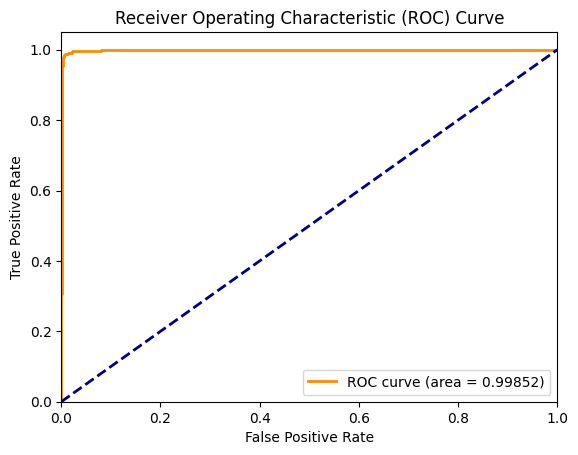

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities (required for ROC curve)
y_prob = model.predict_proba(X_test_features)[:, 1]  # Get probabilities for the positive class (spam)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [27]:
# Extract the messages from the balanced dataset for predictions
input_texts = balanced_data['Message'].tolist()  # Convert to a list

input_texts_features = feature_extraction.transform(input_texts)
# Check predicted probabilities with actual labels
predicted_probabilities = model.predict_proba(input_texts_features)[:, 1]  # Get probabilities for spam
predictions_df = pd.DataFrame({'Message': input_texts, 'Predicted_Probabilities': predicted_probabilities})

# Display first few predictions
print(predictions_df.head(10))

                                             Message  Predicted_Probabilities
0            So what about you. What do you remember                 0.097272
1  My life Means a lot to me, Not because I love ...                 0.050544
2  E admin building there? I might b slightly ear...                 0.078224
3               Sorry, went to bed early, nightnight                 0.033622
4  Someone has conacted our dating service and en...                 0.885101
5  We tried to contact you re your reply to our o...                 0.975690
6  Dear U've been invited to XCHAT. This is our f...                 0.913044
7  * Was a nice day and, impressively, i was sens...                 0.026884
8  YOU ARE CHOSEN TO RECEIVE A £350 AWARD! Pls ca...                 0.970079
9  Kindly send some one to our flat before  &lt;D...                 0.046536


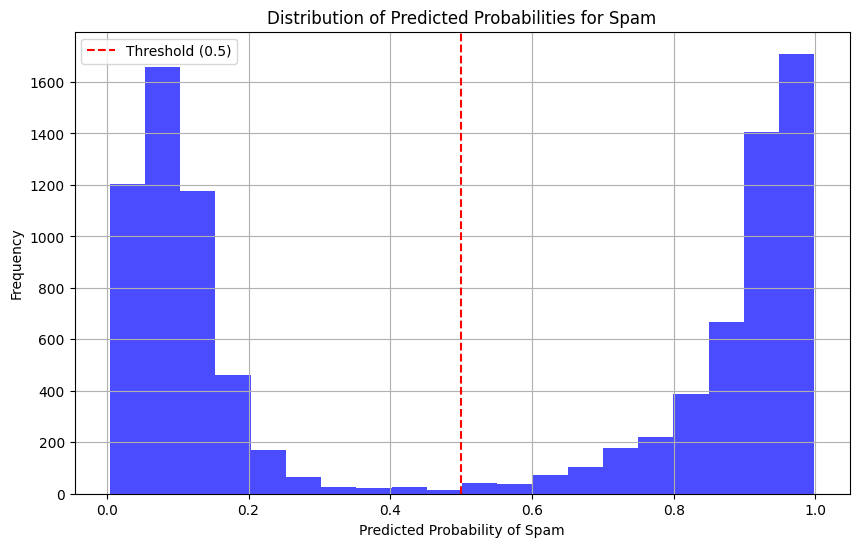

In [28]:
# Create a histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(predicted_probabilities, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities for Spam')
plt.xlabel('Predicted Probability of Spam')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.grid()
plt.show()

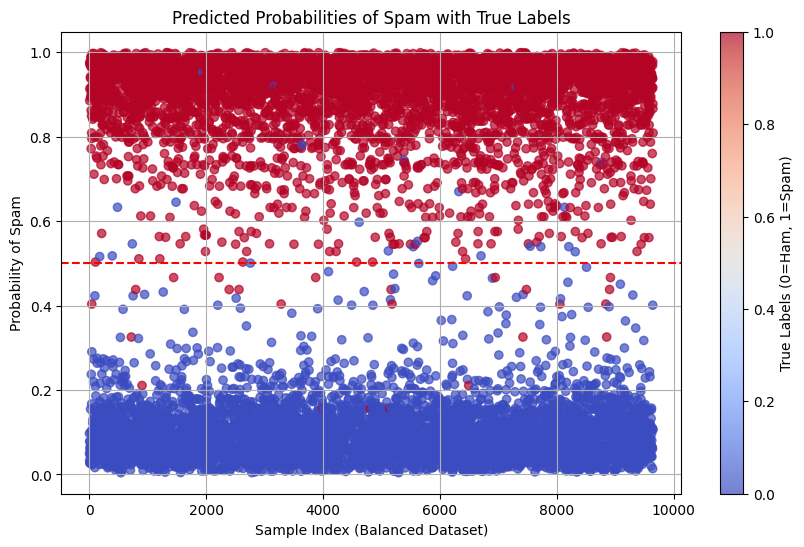

In [29]:
# Create a scatter plot of probabilities with true labels
true_labels = balanced_data['Category'].map({'ham': 0, 'spam': 1}).tolist()  # Convert to numerical labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(input_texts)), predicted_probabilities, c=true_labels, cmap='coolwarm', alpha=0.7)
plt.title('Predicted Probabilities of Spam with True Labels')
plt.xlabel('Sample Index (Balanced Dataset)')
plt.ylabel('Probability of Spam')
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.colorbar(label='True Labels (0=Ham, 1=Spam)')
plt.grid()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions on the test set
y_pred = model.predict(X_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.98912

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       975
           1       0.99      0.99      0.99       955

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



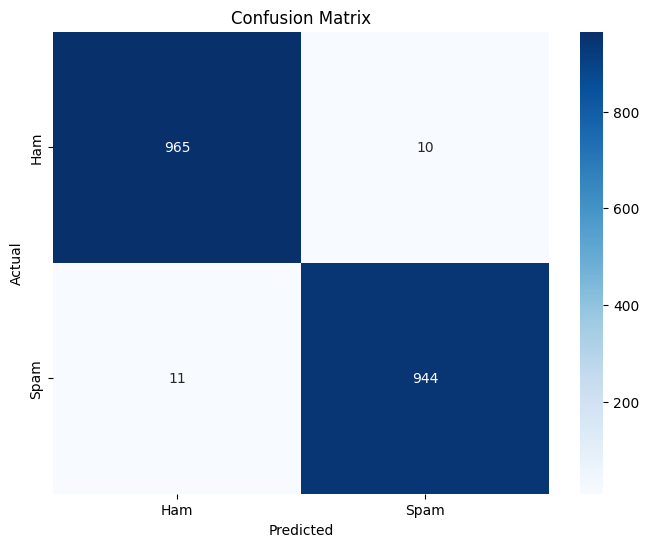

In [31]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [32]:
import joblib

# Load the model (You can do this in a new cell or when you need to use the model)
loaded_model = joblib.load('logistic_regression_model.joblib')

# Function to predict whether a message is spam or ham
def predict_message(message):
    # Convert the message to a list
    message_features = feature_extraction.transform([message])
    # Use the loaded model to predict
    probability = loaded_model.predict_proba(message_features)[:, 1]  # Probability of spam
    prediction = 'Spam' if probability[0] > 0.5 else 'Ham'
    return prediction, probability[0]

In [33]:
# Get user input
user_message = input("Enter a message to classify: ")
print(user_message)

# Predict and display result
prediction, probability = predict_message(user_message)
print(f"The message is classified as: {prediction} (Probability of Spam: {probability:.2f})")

Just forced myself to eat a slice. I'm really not hungry tho. This sucks. Mark is getting worried. He knows I'm sick when I turn down pizza. Lol
The message is classified as: Ham (Probability of Spam: 0.07)


In [34]:
# Get user input
user_message = input("Enter a message to classify: ")
print(user_message)

# Predict and display result
prediction, probability = predict_message(user_message)
print(f"The message is classified as: {prediction} (Probability of Spam: {probability:.2f})")

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
The message is classified as: Spam (Probability of Spam: 0.96)


In [35]:
import tkinter as tk
from tkinter import ttk, messagebox

# Function to check if message is spam or ham
def on_check_clicked():
    user_input = message_entry.get("1.0", tk.END).strip()
    if user_input:
        classification, probability = predict_message(user_input)
        result_display.config(text=f"The message is classified as: {classification}\nProbability of Spam: {probability:.2f}", bg="#ADD8E6")
        result_display.pack(pady=10)
    else:
        messagebox.showwarning("Input Error", "Please enter a message to check.")

# Function to clear the input and result
def on_clear_clicked():
    message_entry.delete("1.0", tk.END)
    result_display.config(text="", bg="white")
    result_display.pack_forget()

# Initialize the tkinter window
root = tk.Tk()
root.title("SPAM DETECTOR")
root.geometry("800x500")  # Increase window size for better spacing
root.configure(bg="#87CEEB")
root.resizable(True, True)

# Heading
heading = tk.Label(root, text="SPAM DETECTOR", font=("Arial", 20), fg="dark blue", bg="#87CEEB")  # Use 'Arial' with larger font size
heading.pack(pady=10)

# Label for instruction
instruction_label = tk.Label(root, text="Enter message to classify:", font=("Arial", 14), fg="black", bg="#87CEEB")
instruction_label.pack(pady=5, anchor='w', padx=(65, 0))

# Textbox for message entry with larger dimensions
message_entry = tk.Text(root, width=60, height=10, wrap=tk.WORD, font=("Arial", 14))  # Use a larger font
message_entry.pack(pady=10)

# Result display label (initially hidden)
result_display = tk.Label(root, text="", font=("Arial", 14), bg="white", fg="black", width=60, height=4, borderwidth=2, relief="groove")
result_display.pack_forget()  # Hide initially

# Buttons
button_frame = tk.Frame(root, bg="#87CEEB")
button_frame.pack(pady=10)

check_button = ttk.Button(button_frame, text="Check", command=on_check_clicked, width=10)
check_button.grid(row=0, column=0, padx=10)

clear_button = ttk.Button(button_frame, text="Clear", command=on_clear_clicked, width=10)
clear_button.grid(row=0, column=1, padx=10)

# Bind the Enter key to trigger the Check button without adding a new line
root.bind('<Return>', lambda event: (on_check_clicked(), "break"))

# Start the tkinter loop
root.mainloop()